# MLB Analytics Pipeline

### Necessary Imports

In [207]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
from matplotlib import cm 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

### Matplotlib Colors Class

In [203]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# Gather Data

### Function to Web-Scrape Player Game Logs

In [182]:
# Pitchers - ERA is their season avg at that time

def scrape_gamelogs(year, player_id, cat):
    df_player=pd.DataFrame()
    tables = pd.read_html(f'https://www.espn.com/mlb/player/gamelog/_/id/{player_id}/year/{year}/category/{cat}')
    for i in range(len(tables)-1):
        try:
            df_player = df_player.append(tables[i])
        except: break
    df_player = df_player.iloc[::-1].reset_index(drop=True)
    df_player.loc[0,['Date','OPP','Result']] = 'Totals'
    
    try: df_player = df_player.drop(columns=['Regular Season Stats'])
    except: pass
    
    months = ['april','may','june','july','august','september','october','Postseason','Totals']
    df_totals = pd.DataFrame()
    for i in months:
        try:
            df_totals = df_totals.append(df_player.loc[df_player['Date'] == i]).reset_index(drop=True)
            df_player = df_player[df_player.Date != i]
        except: pass
    
    try: df_totals = df_totals.drop(columns=['OPP','Result'])
    except: pass
    
    df_totals.Date = df_totals.Date.str.capitalize()
    
    return df_player, df_totals

df_gonzalez_box, df_gonzalez_totals = scrape_gamelogs(2022, 39400, 'batting')
display(df_gonzalez_totals)
display(df_gonzalez_box)

,Date,AB,R,H,2B,3B,HR,RBI,BB,HBP,SO,SB,CS,AVG,OBP,SLG,OPS
0,May,21,2,9,3,0,0,2,0,0,3,0,0,0.429,0.429,0.571,1.000
1,June,102,10,26,9,0,2,12,5,1,25,0,0,0.255,0.294,0.402,0.696
2,August,98,7,28,8,0,3,9,3,0,23,1,1,0.286,0.307,0.459,0.766
3,September,121,15,36,5,0,6,20,6,2,21,0,1,0.298,0.338,0.488,0.826
4,October,20,5,8,2,0,0,0,1,0,3,0,0,0.400,0.429,0.500,0.929
5,Postseason,31,2,7,0,0,1,4,0,1,9,0,0,0.226,0.250,0.323,0.573
6,Totals,362,39,107,27,0,11,43,15,3,75,1,2,0.296,0.327,0.461,0.789


,Date,OPP,Result,AB,R,H,2B,3B,HR,RBI,BB,HBP,SO,SB,CS,AVG,OBP,SLG,OPS
2,Thu 5/26,@DET,L4-3,4,0,2,1,0,0,0,0,0,0,0,0,0.500,0.500,0.750,1.250
3,Sat 5/28,@DET,W8-1,4,0,2,1,0,0,0,0,0,0,0,0,0.500,0.500,0.750,1.250
4,Sun 5/29,@DET,L2-1,4,0,1,0,0,0,0,0,0,2,0,0,0.417,0.417,0.583,1.000
5,Mon 5/30,vsKC,W7-3,4,1,2,0,0,0,0,0,0,1,0,0,0.438,0.438,0.563,1.000
6,Tue 5/31,vsKC,W8-3,5,1,2,1,0,0,2,0,0,0,0,0,0.429,0.429,0.571,1.000
8,Wed 6/1,vsKC,W4-0,4,0,0,0,0,0,0,0,0,1,0,0,0.360,0.360,0.480,0.840
9,Fri 6/3,@BAL,W6-3,4,0,2,0,0,0,0,0,0,0,0,0,0.379,0.379,0.483,0.862
10,Sat 6/4,@BAL,L5-4,4,1,1,0,0,0,0,0,0,0,0,0,0.364,0.364,0.455,0.818
11,Sun 6/5,@BAL,W3-2,3,0,1,0,0,0,0,1,0,1,0,0,0.361,0.378,0.444,0.823
12,Tue 6/7,vsTEX,W6-3,4,0,2,2,0,0,1,0,0,0,0,0,0.375,0.390,0.500,0.890


### Function to Web-Scrape Player Splits

In [222]:
def scrape_splits(year, player_id, cat):
    df_player=pd.DataFrame()
    tables = pd.read_html(f'https://www.espn.com/mlb/player/splits/_/id/{player_id}/year/{year}/category/{cat}')
    for i in range(len(tables)-1):
        try:
            df_player = pd.concat([df_player, tables[i]], axis=1)
        except: break
            
    df_player.columns = df_player.iloc[0]
    df_player['Cat'] = ''
    cats = ['Overall','Opponent Batting', 'Breakdown', 'Right / Left','Day / Month','Opponent','Stadium','Position','Count','Batting Order','Situation','Inning Pitches','Rest (as reliever)']
    for i in range(len(df_player)):
        for j in cats:
            if df_player.Overall[i] ==j:
                x=j
        df_player.Cat[i] = x
    
    for i in cats:
        df_player = df_player[df_player.Overall != i]
    
    df_player = df_player.rename(columns={'Cat':'Category','Overall':'Condition'})
    
    pivot_player = df_player.groupby(['Category','Condition']).first()
    
    first_column = df_player.pop('Category')
    df_player.insert(0, 'Category', first_column)
    
    return df_player, pivot_player

df_clase_split, pivot_clase_split = scrape_splits(2022, 41743, 'pitching')
display(pivot_clase_split)
#display(df_clase_split)

0                                             ERA   W   L  SV SVOP  GP  GS  \
Category           Condition                                                 
Batting Order      Batting #1                  26   3   6   1    0   0   3   
                   Batting #2                  26   1   2   0    0   0   0   
                   Batting #3                  27   5   7   0    0   1   5   
                   Batting #4                  25   0   1   1    0   0   0   
                   Batting #5                  27   3   3   1    0   0   3   
                   Batting #6                  31   0   5   0    0   0   0   
                   Batting #7                  37   3  10   1    0   2   3   
                   Batting #8                  28   3   4   2    0   0   3   
                   Batting #9                  31   2   5   0    0   0   1   
Breakdown          Away                      2.34   2   4  25   29  39   0   
                   Day                       1.82   1   2  15   16  26   0   
                   Home                      0.47   1   0  17   17  38   0   
                   Night                     1.13   2   2  27   30  51   0   
Count              Count 0-0                   32   5  10   1    0   1   4   
                   Count 0-1                   27   3   9   1    0   1   3   
                   Count 0-2                   60   2   7   3    0   1   2   
                   Count 1-0                   20   2   2   0    0   0   2   
                   Count 1-1                   20   0   0   0    0   0   0   
                   Count 1-2                   52   4   5   1    0   0   4   
                   Count 2-0                    3   1   1   0    0   0   1   
                   Count 2-1                    7   0   1   0    0   0   0   
                   Count 2-2                   26   3   6   0    0   0   2   
                   Count 3-0                    0   0   0   0    0   0   0   
                   Count 3-1                    1   0   0   0    0   0   0   
                   Count 3-2                   10   0   2   0    0   0   0   
Day / Month        April                     4.91   0   2   4    5   9   0   
                   August                    0.79   0   1   7    7  13   0   
                   July                      0.90   0   0   5    5  10   0   
                   June                      0.00   1   0  11   11  15   0   
                   Last 15 Days              1.13   0   0   6    6   8   0   
                   Last 30 Days              2.40   1   1  11   13  16   0   
                   Last 7 Days               0.00   0   0   3    3   3   0   
                   May                       0.82   1   0   3    4  11   0   
                   October                   0.00   0   0   2    2   2   0   
                   September                 2.25   1   1  10   12  17   0   
Inning Pitches     1st Time Faced In Game     258  20  43   6    0   3  18   
                   2nd Time Faced In Game       0   0   0   0    0   0   0   
                   3rd Time Faced In Game       0   0   0   0    0   0   0   
                   4th+ Time Faced In Game      0   0   0   0    0   0   0   
Opponent           vs. ARI                   0.00   0   0   0    0   1   0   
                   vs. BAL                   0.00   0   0   2    2   3   0   
                   vs. BOS                   0.00   0   0   1    1   2   0   
                   vs. CHW                   1.00   2   0   5    7   9   0   
                   vs. CIN                   4.50   0   0   0    0   2   0   
                   vs. COL                   0.00   0   0   3    3   3   0   
                   vs. DET                   1.23   0   0   3    3   8   0   
                   vs. HOU                   3.00   0   0   1    1   3   0   
                   vs. KC                    4.70   0   2   4    5   9   0   
                   vs. LAA                   0.00   0   0   2    2   3   0   
                   vs.

# Statistical Analysis

### Multi Linear Regression Model Function

In [185]:
#x - as list - can be as small as 1 variable and up to as many as desired
#y - as string

def multi_lin_reg(df,x,y):
    x = df[x]
    x = sm.add_constant(x)
    y = df[y]
    model = sm.OLS(y, x).fit()
    print(model.summary())
    
multi_lin_reg(df_gonzalez_box, ['H','HR','RBI'],'AB')

                            OLS Regression Results                            
Dep. Variable:                     AB   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     11.83
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           0.000862
Time:                        16:55:57   Log-Likelihood:                -106.80
No. Observations:                  98   AIC:                             217.6
Df Residuals:                      96   BIC:                             222.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6916      0.118     31.234      0.0

# Data/Statistical Visualizations

### Function to return the name of a specified dataframe

In [200]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

### Statistical Regression Analysis and Visualization Function

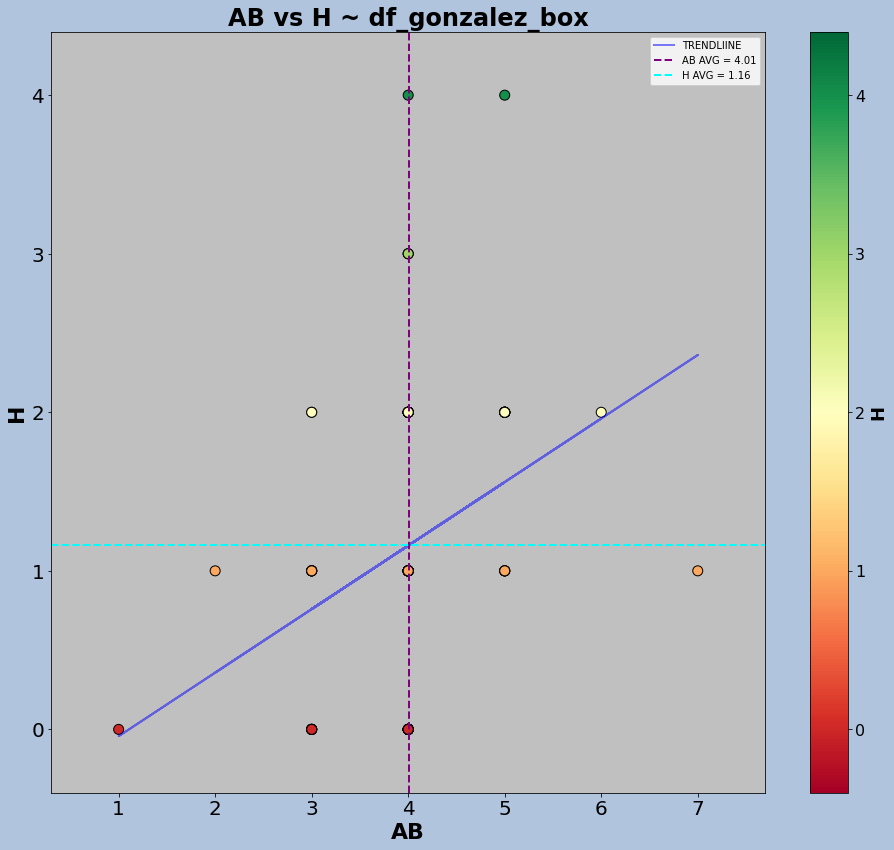


Season Trend Line Equation: y = 0.400716x + (-0.443688)

R-squared: 0.10974092814690084

                            OLS Regression Results                            
Dep. Variable:                      H   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     11.83
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           0.000862
Time:                        17:21:55   Log-Likelihood:                -125.45
No. Observations:                  98   AIC:                             254.9
Df Residuals:                      96   BIC:                             260.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [224]:
def stat_reg_analysis(df, statx, staty, cbar_rev=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))
    df_new = df.copy()
    
    x=pd.to_numeric(df_new[statx]).fillna(0)
    y=pd.to_numeric(df_new[staty]).fillna(0)
    
    initial_cmap = cm.get_cmap('RdYlGn')
    reversed_cmap=initial_cmap.reversed()

    # Calc the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.5, color='blue', linewidth=2)
    

    if cbar_rev:
        plt.scatter(x,y, c=y, cmap=reversed_cmap, s=100, edgecolor='black')
    else:
        plt.scatter(x,y, c=y, cmap=initial_cmap, s=100, edgecolor='black')

    plt.axvline(x.mean(), label=f"{statx} AVG = {round(x.mean(),2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(y.mean(), label=f"{staty} AVG = {round(y.mean(),2)}", linestyle='dashed', color='cyan', linewidth=2)
    
    xmin = x.min()-(x.max()*.1)
    ymin = y.min()-(y.max()*.1)
    
    xmax = x.max()+(x.max()*.1)
    ymax = y.max()+(y.max()*.1)

    plt.xlabel(statx, fontsize=22, fontweight='bold')
    plt.ylabel(staty, fontsize=22, fontweight='bold')
    
    plt.legend(loc='best', prop={'weight':'bold', 'size':14})

    ax.set_facecolor('silver')
    fig.set_facecolor('lightsteelblue')
    fig.set_edgecolor('black')

    plt.title(f'{statx} vs {staty} ~ {get_df_name(df)}', fontsize=24, fontweight='bold')
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.clim(ymin,ymax)
    
    cbar = plt.colorbar(cmap='RdYlGn')

    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(label=staty, size=18, weight='bold')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.legend(loc='best')
    
    plt.show()

    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)"%(z[0],z[1]))

    # Calc R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: "+ color.END + str(r_squared))
    print()
    
    lm = smf.ols(formula = f'{staty} ~ {statx}', data=df_new).fit()
    print(lm.summary())

stat_reg_analysis(df_gonzalez_box, 'AB', 'H', cbar_rev=False)

### 3D Scatter Plot Function

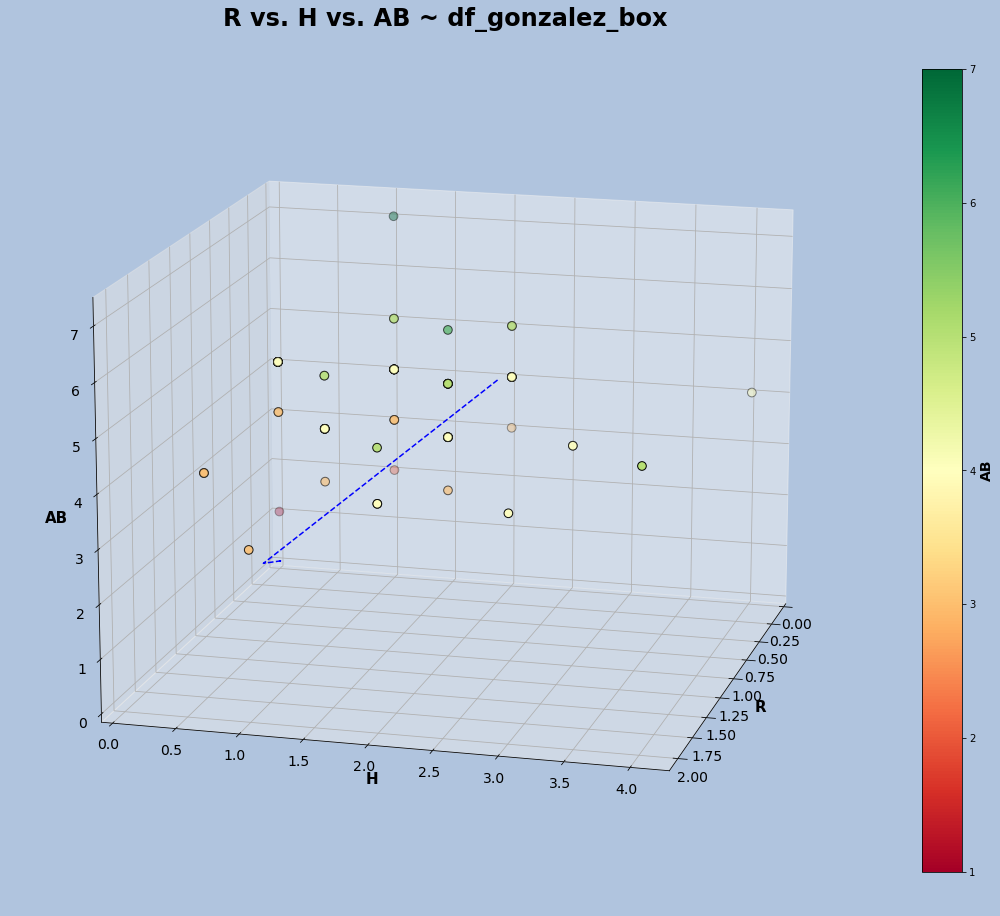

In [239]:
def scatter_3d(df,x,y,z, xview=15, yview=15,zview=0, sv_anim=False):
    initial_cmap = cm.get_cmap('RdYlGn')
    reversed_cmap=initial_cmap.reversed()
    
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(projection='3d')
    
    ax.set_facecolor('lightsteelblue')
    fig.set_facecolor('lightsteelblue')
    
    ax.set_xlabel(x, fontweight='bold', fontsize=15)
    ax.set_ylabel(y, fontweight='bold', fontsize=15)
    ax.set_zlabel(z, fontweight='bold', fontsize=15)
    
    xdata=df[x].fillna(0)
    ydata=df[y].fillna(0)
    zdata=df[z].fillna(0)
    
    # Function to create s value base on the 3 values
    
    sc = ax.scatter(xdata,ydata,zdata,c=zdata, cmap=initial_cmap, edgecolor='black', s=75)

    cbar = fig.colorbar(sc, ax=ax, fraction=0.042, pad=0.04)
    cbar.set_label(z, fontsize=14, fontweight='bold')
    
    t = np.arange(df.shape[0])

    fitx = np.polyfit(t, xdata, 5)
    fity = np.polyfit(t, ydata, 5)
    fitz = np.polyfit(t, zdata, 5)

    ax.plot(fitx,fity,fitz, color='blue', linestyle='dashed')
    
    plt.xlim(0,None)
    plt.ylim(0,None)
    ax.set_zlim(0,None)
    
    plt.title(f'{x} vs. {y} vs. {z} ~ {get_df_name(df)}', fontweight='bold', fontsize=24)
    plt.grid()
    plt.tight_layout()
    
    ax.view_init(xview,yview,zview)
    
    for t in ax.xaxis.get_major_ticks(): t.label1.set_fontsize(14)
    for t in ax.yaxis.get_major_ticks(): t.label1.set_fontsize(14)
    for t in ax.zaxis.get_major_ticks(): t.label1.set_fontsize(14)
        
    if sv_anim:
        
        def init():
            ax.view_init(elev=15., azim=0)
            return [sc]
        
        def animate(i):
            ax.view_init(elev=15., azim=i)
            return [sc]
        
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
        
        plt.show()
        
        try: os.mkdir('C:\\Users\\Peter\\NBA_3D_Scatter_Anims')
        except: pass
        
        try: ani.save(f'C:\\Users\\Peter\\NBA_3D_Scatter_Anims\\{x}_{y}_{z}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        except: pass
        
    
    else:
        plt.show()
        
scatter_3d(df_gonzalez_box,'R','H','AB', sv_anim=False)

# Go to save location to view animation
# TODO: Display animation, currently having issues, but saved video is available